<a href="https://colab.research.google.com/github/PhiloAmgad/CVD-19-Diagnosis-using-ML/blob/main/GLCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import nibabel as nib
import cv2 as cv
from sklearn import feature_selection
import scipy as sp
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm
from PIL import Image
import matplotlib as mpl
import imageio
import matplotlib.pyplot as plt

from IPython.display import display

from skimage.feature import hog
from skimage.color import rgb2grey
from skimage.io import imread

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

from google.colab.patches import cv2_imshow
from skimage.feature import greycomatrix, greycoprops
from skimage import data


import glob
import seaborn as sns
from skimage.filters import sobel
from skimage.measure import shannon_entropy
! pip install pyradiomics
import SimpleITK as sitk
import six
import logging
import radiomics
from radiomics import featureextractor, getTestCase, glcm




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#transformations for matplot lib
mask_data = nib.load(r'/content/drive/MyDrive/Semester 8/tr_mask.nii').get_fdata()
func_data = nib.load(r'/content/drive/MyDrive/Semester 8/tr_im.nii').get_fdata()
lung_mask_data = nib.load(r'/content/drive/MyDrive/Semester 8/tr_lungmasks_updated.nii').get_fdata()

print(func_data)
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [ ]:
lung_mask_data_unmod = nib.load(r'tr_lungmasks_updated.nii').get_fdata()
MaskSlice = mask_data[:, :, 16]
dataSlice = func_data[:, :, 16]
lungMaskSlice = lung_mask_data[:, :, 16]
#X32 = dataSlice[288:320,288:320]
mdSlice= cv.bitwise_and(MaskSlice,dataSlice)
ldSlice = cv.bitwise_and(lungMaskSlice,dataSlice)
show_slices([MaskSlice, dataSlice, lungMaskSlice,mdSlice,ldSlice])

#show_slices([lungMaskSlice,MaskSlice,X32])
plt.suptitle("CT Test")
lungSliceArray = np.array(lungMaskSlice)
mdSliceArray = np.array(mdSlice)
maskSliceArray = np.array(MaskSlice)
dataSliceArray = np.array(dataSlice)
dataSliceArrayII = dataSliceArray.astype(np.uint8).copy()
maskSliceArrayII = maskSliceArray.astype(np.uint8).copy()
#pltimg = plt.imread('testPatch.jpg')
# opencvimg = cv.imread('testPatchII.png')
# cv.imshow('Open CV',opencvimg)
# cv.waitKey(0)
# cv.destroyAllWindows()
#plt.imshow(pltimg)
print(f'Unique values of Lung Mask are : {np.unique(lungSliceArray)}')
print(f'Unique values of  Mask are : {np.unique(maskSliceArray)}')
print(f'Select value is : {maskSliceArray[400][270]}')
#mpl.image.imsave('testPatchII.jpg', X32)
#imageio.imwrite('testPatchII.png', X32)

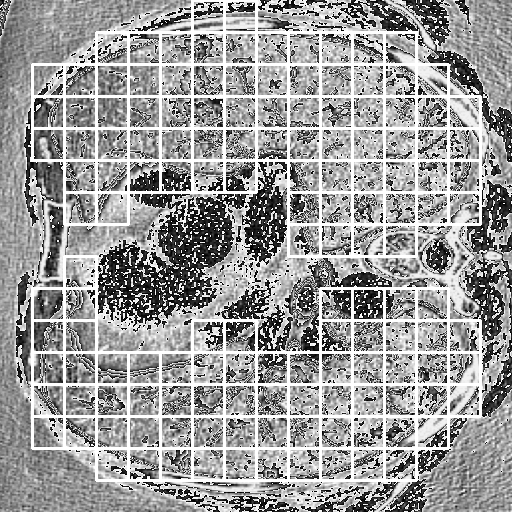

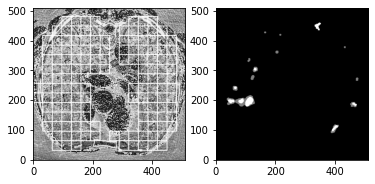

In [ ]:
# test for identifying infected 32x32 patche to create dataset 1
def checkForWhite(arr):
    for i in len(arr):
        if arr[i]>0:
            return True

    return False

def checkForWhitePatch(x,y,imgArr):
    x*=32
    y*=32
    for i in range(x,x+32):
        for j in range(y,y+32):
            if imgArr[i][j]>0:
                return True
    return False

#function to run 32 by 32 with a contains function, 16 patches per row

i =0
detectedArr = []
for i in range(16):
   # if(checkForWhite(np.unique(array_2[i]))):
        for j in range(16):
            if(checkForWhitePatch(i,j,lungSliceArray)):
                #cv.rectangle(array_2,(i*32,j*32),(((i*32)+32,(j*32)+32)),(255,255,255),thickness=2)
                detectedArr.append((i,j))
#show_slices([slice_0, slice_1, slice_2])
for c in range(len(detectedArr)) :
    cv.rectangle(dataSliceArrayII,(detectedArr[c][1]*32,detectedArr[c][0]*32),(((detectedArr[c][1]*32)+32,(detectedArr[c][0]*32)+32)),(255,255,255),thickness=2)

cv2_imshow(dataSliceArrayII)
cv.waitKey(0)
cv.destroyAllWindows()
image2  = Image.fromarray(np.uint8(dataSliceArrayII * 255) , 'L')
image2.show()
affine = np.eye(4)
nifti_file = nib.Nifti1Image(dataSliceArrayII, affine).get_fdata()
show_slices([nifti_file,MaskSlice])

In [ ]:
test = imageio.imread(r'/content/drive/MyDrive/Semester_8/Healthy32x32/10000_10001.png')
print(test)

[[167 171 177 ... 220 193 207]
 [148 187 173 ... 218 197 210]
 [137 194 164 ... 218 205 215]
 ...
 [239 212 218 ...  58  13  29]
 [255 179 243 ...  46  46  61]
 [231 174 218 ...  12  61  23]]


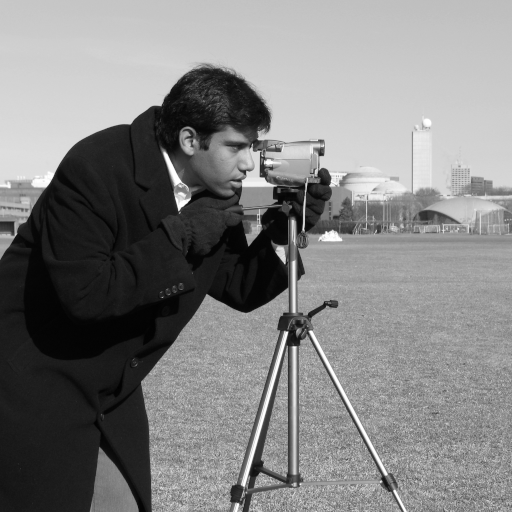

In [ ]:
PATCH_SIZE = 32
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
image = data.camera()
cv2_imshow(image)
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])
sky_locations = [(38, 34), (139, 28), (37, 437), (145, 379)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])


(-0.5, 511.5, 511.5, -0.5)

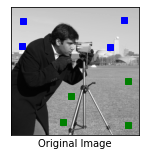

In [ ]:
# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])
fig = plt.figure(figsize=(8, 8))
# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

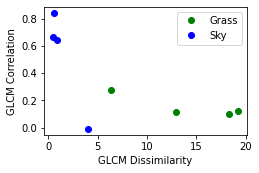

In [ ]:
# for each patch, plot (dissimilarity, correlation)
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(3, 2, 2)
ax1.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax1.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax1.set_xlabel('GLCM Dissimilarity')
ax1.set_ylabel('GLCM Correlation')
ax1.legend()

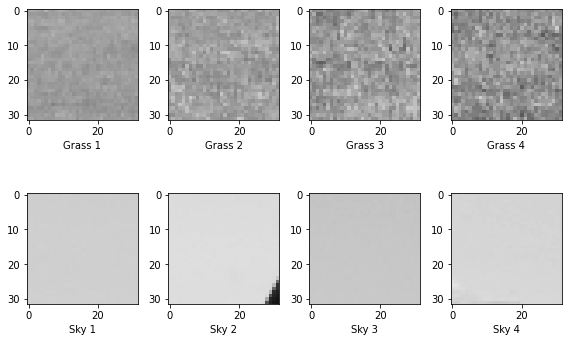

In [ ]:
# display the image patches
fig1 = plt.figure(figsize=(8, 8))
for i, patch in enumerate(grass_patches):
    ax1 = fig1.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax1.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax1.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax1 = fig1.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax1.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax1.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
DATADIR = r'/content/drive/MyDrive/Semester_8'
Categories=['LSNonInfected32x32HEII','LSINfected32x32HEII','01NonInfected32x32HE','01Infected32x32HE','02NonInfected32x32HE','02Infected32x32HE','03Infected32x32HE'
,'04NonInfected32x32HE','04Infected32x32HE','05NonInfected32x32HE','05Infected32x32HE','08NonInfected32x32HE','08Infected32x32HE']

X=[]
y=[]
i=0

for i in Categories:
    path=os.path.join(DATADIR,i)
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = cv.imread(newpath,0)
      imArr = np.array(image)
      #print(imArr)
      X.append(imArr)
      y.append(i[2])

print(X[0])

# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=.3,
#                                                     random_state=1234123)

[[ 22 116 176 ... 224 238 232]
 [ 40  93 105 ... 238 241 235]
 [ 93  79  48 ... 242 245 235]
 ...
 [129 141 176 ... 189 169  28]
 [141 161 189 ... 189 116  28]
 [105 141 196 ... 196  93  28]]


In [ ]:
DATADIR = r'/content/drive/MyDrive/Semester_8'
Categories=['M2IHEHel32x32','M2IHEInf32x32']
X=[]
y=[]
i=0
# zzz =   sitk.ReadImage(newpath)
# print(zzz)

for i in Categories:
    path=os.path.join(DATADIR,i)
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = sitk.ReadImage(newpath)
      imArr = np.array(image)
      #print(imArr)
      X.append(image)
      y.append(i)

print(X[0])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
test_labels_encoded = le.transform(y)
print(len(test_labels_encoded))
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    test_labels_encoded,
                                                    random_state=8,
                                                    test_size=.2)
print(y)

8859
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [ ]:
y_test

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        img = dataset[image]
        print(img)
        ip = radiomics.glcm.RadiomicsGLCM._initCalculation(img)
        #START ADDING DATA TO THE DATAFRAME
        #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        #GLCM = greycomatrix(img, [1], [0])
        ###### FEATURES #####
        # GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        # df['Energy'] = GLCM_Energy
        #correlation
        GLCM_corr = radiomics.glcm.RadiomicsGLCM.getCorrelationFeatureValue(ip)
        df['Corr'] = GLCM_corr
        #dissimilarity
        GLCM_diss = radiomics.glcm.RadiomicsGLCM.getDifferenceAverageFeatureValue(ip)
        df['Diss_sim'] = GLCM_diss
        #homogeneity i.e inverse difference
        GLCM_hom = radiomics.glcm.RadiomicsGLCM.getIdFeatureValue(ip)
        df['Homogen'] = GLCM_hom
        #contrast
        GLCM_contr = radiomics.glcm.RadiomicsGLCM.getContrastFeatureValue(ip)
        df['Contrast'] = GLCM_contr
        #entropy
        entropy = shannon_entropy(ip)
        df['Entropy'] = entropy
        #angular secondary moment
        GLCM_ASM = radiomics.glcm.RadiomicsGLCM.getJointEnergyFeatureValue(ip)
        df['ASM'] = GLCM_ASM
        #sum of squares
        GLCM_SSQ= radiomics.glcm.RadiomicsGLCM.getSumSquaresFeatureValue(ip)
        df['SSQ'] = GLCM_SSQ
        #inverse difference moment
        GLCM_IDM= radiomics.glcm.RadiomicsGLCM.getIdmFeatureValue(ip)
        df['IDM'] = GLCM_IDM
        #sum average
        GLCM_SA= radiomics.glcm.RadiomicsGLCM.getSumAverageFeatureValue(ip)
        df['SA'] = GLCM_SA
        #sum variance
        GLCM_SV= radiomics.glcm.RadiomicsGLCM.getClusterTendencyFeatureValue(ip)
        df['SV'] = GLCM_SV
        #sum entropy
        GLCM_SE= radiomics.glcm.RadiomicsGLCM.getSumEntropyFeatureValue(ip)
        df['SE'] = GLCM_SE
        #difference entropy (13)
        GLCM_DE= radiomics.glcm.RadiomicsGLCM.getDifferenceEntropyFeatureValue(ip)
        df['DE'] = GLCM_DE
        #difference variance
        GLCM_DV= radiomics.glcm.RadiomicsGLCM.getDifferenceVarianceFeatureValue(ip)
        df['DV'] = GLCM_DV
        #informational measures of correlation 1
        GLCM_IMC1= radiomics.glcm.RadiomicsGLCM.getImc1FeatureValue(ip)
        df['IMC1'] = GLCM_IMC1
        #informational measures of correlation 2
        GLCM_IMC2= radiomics.glcm.RadiomicsGLCM.getImc2FeatureValue(ip)
        df['IMC2'] = GLCM_IMC2
        #autocorrelation
        GLCM_AC= radiomics.glcm.RadiomicsGLCM.getAutocorrelationFeatureValue(ip)
        df['AC'] = GLCM_AC
        #cluster shade
        GLCM_CS= radiomics.glcm.RadiomicsGLCM.getClusterShadeFeatureValue(ip)
        df['CS'] = GLCM_CS
        #cluster prominence
        GLCM_CP= radiomics.glcm.RadiomicsGLCM.getClusterProminenceFeatureValue(ip)
        df['CP'] = GLCM_CP
        #maximum probability (20)
        GLCM_MP= radiomics.glcm.RadiomicsGLCM.getMaximumProbabilityFeatureValue(ip)
        df['MP'] = GLCM_MP

        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset

In [ ]:
print( len(X[12][1]))

3


In [ ]:
#another try with GLCM features
from radiomics import firstorder,  imageoperations, shape, shape2D
settings = {'binWidth': 1,
            'interpolator': sitk.sitkBSpline,
            'resampledPixelSpacing': None}
trialImg = sitk.GetImageFromArray(X[0])
# im_size = im.GetSize()[::-1]  # size in z, y, x, needed because the arrays obtained from the image are oriented in z, y, x

ma_arr = np.ones([64,64], dtype='uint8')
ma = sitk.GetImageFromArray(ma_arr)
ma.CopyInformation(trialImg)  # This copies the geometric information, ensuring image and mask are aligned. This works, because image and mask have the same size of the pixel array

sitk.WriteImage(ma, r'/content/drive/MyDrive/Semester_8/mask64.nrrd', True)  # don't forget the extension!, True specifies it can be compressed for storage (only used for masks)

trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester_8/mask64.nrrd')
applyLog = False
applyWavelet = True
interpolator = settings.get('interpolator')
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
  image, mask = imageoperations.resampleImage(trialImg, trialMask, **settings)

bb, correctedMask = imageoperations.checkMask(trialImg, trialMask)
if correctedMask is not None:
  mask = correctedMask
print(f'Before :{sitk.GetArrayFromImage(trialImg)}')
image, mask = imageoperations.cropToTumorMask(trialImg, trialMask, bb)
print(f'Aftre :{sitk.GetArrayFromImage(trialImg)}')
#


glcmFeatures = glcm.RadiomicsGLCM(trialImg, trialMask ,**settings)
glcmFeatures.enableFeatureByName('JointEnergy',True)
glcmFeatures.enableFeatureByName('Contrast',True)
glcmFeatures.enableFeatureByName('Correlation',True)
glcmFeatures.enableFeatureByName('SumSquares',True)
glcmFeatures.enableFeatureByName('Idm',True)
glcmFeatures.enableFeatureByName('SumAverage',True)
glcmFeatures.enableFeatureByName('ClusterTendency',True)
glcmFeatures.enableFeatureByName('SumEntropy',True)
# glcmFeatures.enableFeatureByName('Entropy',True)
glcmFeatures.enableFeatureByName('DifferenceEntropy',True)
glcmFeatures.enableFeatureByName('DifferenceVariance',True)
glcmFeatures.enableFeatureByName('Imc1',True)
glcmFeatures.enableFeatureByName('Imc2',True)
glcmFeatures.enableFeatureByName('Autocorrelation',True)
glcmFeatures.enableFeatureByName('DifferenceAverage',True)
glcmFeatures.enableFeatureByName('ClusterShade',True)
glcmFeatures.enableFeatureByName('ClusterProminence',True)
glcmFeatures.enableFeatureByName('MaximumProbability',True)
glcmFeatures.enableFeatureByName('Id',True)

print('Will calculate the following GLCM features: ')
for f in glcmFeatures.enabledFeatures.keys():
  print('  ', f)
  print(getattr(glcmFeatures, 'get%sFeatureValue' % f).__doc__)

print('Calculating GLCM features...')
resultsII = glcmFeatures.execute()
print('done')

print('Calculated GLCM features: ')
arrTrX = []
for (key, val) in six.iteritems(resultsII):
  print('  ', key, ':', val)
  arrTrX.append(float(val))
arrTrX

In [ ]:
#another another try with features
def feature_extractorII(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):  #iterate through each file
        #print(image)

        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        img = dataset[image]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME


         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])
        print(len(GLCM[0]))
        break
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr

        #Add more filters as needed
        #entropy = shannon_entropy(img)
        #df['Entropy'] = entropy


        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset

In [ ]:
# print(len(image_features))
# print(image_features.iloc[0])
eskot = []
i=0
j=0
for i in range(32):
  Odarr=[]
  for j in range(32):
    Odarr.append(1)
  eskot.append(Odarr)
print(eskot)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 

In [ ]:
#another another another try with features
import statistics
def feature_extractorIII(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):  #iterate through each file
        #print(image)
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.

        img = dataset[image]
        # print('GLCM')
    ################################################################
    #START ADDING DATA TO THE DATAFRAME


         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])
        # print('GLCM')
        # print(GLCM)

        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr

        #Add more filters as needed
        entropy = shannon_entropy(img)
        df['Entropy'] = entropy

        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)

    return image_dataset


In [ ]:

from radiomics import firstorder,  imageoperations, shape, shape2D
settings = {'binWidth': 1,
            'interpolator': sitk.sitkBSpline,
            'resampledPixelSpacing': None}
# im_size = im.GetSize()[::-1]  # size in z,
def feature_extractorGLCM(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(dataset[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester_8/mask.nrrd')
        applyLog = True
        applyWavelet = True
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)




        glcmFeatures = glcm.RadiomicsGLCM(iterImg, trialMask ,**settings)
        glcmFeatures.enableFeatureByName('JointEnergy',True)
        glcmFeatures.enableFeatureByName('Contrast',True)
        glcmFeatures.enableFeatureByName('Correlation',True)
        glcmFeatures.enableFeatureByName('SumSquares',True)
        glcmFeatures.enableFeatureByName('Idm',True)
        glcmFeatures.enableFeatureByName('SumAverage',True)
        glcmFeatures.enableFeatureByName('ClusterTendency',True)
        glcmFeatures.enableFeatureByName('SumEntropy',True)
        # glcmFeatures.enableFeatureByName('Entropy',True)
        glcmFeatures.enableFeatureByName('DifferenceEntropy',True)
        glcmFeatures.enableFeatureByName('DifferenceVariance',True)
        glcmFeatures.enableFeatureByName('Imc1',True)
        glcmFeatures.enableFeatureByName('Imc2',True)
        glcmFeatures.enableFeatureByName('Autocorrelation',True)
        glcmFeatures.enableFeatureByName('DifferenceAverage',True)
        glcmFeatures.enableFeatureByName('ClusterShade',True)
        glcmFeatures.enableFeatureByName('ClusterProminence',True)
        glcmFeatures.enableFeatureByName('MaximumProbability',True)
        glcmFeatures.enableFeatureByName('Id',True)

        radiomics.setVerbosity(40)
        results = glcmFeatures.execute()
        df = pd.DataFrame()
        #print(results['JointEnergy'])
        #Append features from current image to the dataset
        df = df.append({'JointEnergy': results['JointEnergy'],
                       'Contrast': results['Contrast'],
                       'Correlation': results['Correlation'],
                       'SumSquares': results['SumSquares'],
                       'Idm': results['Idm'],
                       'SumAverage': results['SumAverage'],
                       'ClusterTendency': results['ClusterTendency'],
                       'DifferenceEntropy': results['DifferenceEntropy'],
                       'DifferenceVariance': results['DifferenceVariance'],
                       'Imc1': results['Imc1'],
                       'Imc2': results['Imc2'],
                       'Autocorrelation': results['Autocorrelation'],
                       'DifferenceAverage': results['DifferenceAverage'],
                       'ClusterShade': results['ClusterShade'],
                       'ClusterProminence': results['ClusterProminence'],
                       'MaximumProbability': results['MaximumProbability'],
                       'Id': results['Id'],
                       },
                       ignore_index=True)
        image_dataset = image_dataset.append(df,ignore_index=True)
    return image_dataset

In [ ]:
from pandas.core.indexes.numeric import IntegerIndex
def feature_extractorFOS(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(dataset[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester_8/mask.nrrd')
        applyLog = False
        applyWavelet = False
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)

        bb, correctedMask = imageoperations.checkMask(iterImg, trialMask)
        if correctedMask is not None:
          mask = correctedMask
        image, mask = imageoperations.cropToTumorMask(iterImg, trialMask, bb)


        firstOrderFeatures = firstorder.RadiomicsFirstOrder(iterImg, trialMask, **settings)
        # firstOrderFeatures.enableFeatureByName('Kurtosis',True)
        # firstOrderFeatures.enableFeatureByName('Mean',True)
        # firstOrderFeatures.enableFeatureByName('Variance',True)
        # firstOrderFeatures.enableFeatureByName('Skewness',True)
        # firstOrderFeatures.enableFeatureByName('Energy',True)
        # firstOrderFeatures.enableFeatureByName('Entropy',True)
        firstOrderFeatures.enableAllFeatures()

        results = firstOrderFeatures.execute()
        df = pd.DataFrame()
        #Append features from current image to the dataset
        df = df.append({'Energy': results['Energy'],
                        'TotalEnergy': results['TotalEnergy'],
                        'Entropy': results['Entropy'],
                        'Minimum': results['Minimum'],
                        '10Percentile': results['10Percentile'],
                        '90Percentile': results['90Percentile'],
                        'Maximum': results['Maximum'],
                        'Mean': results['Mean'],
                        'Median': results['Median'],
                        'InterquartileRange': results['InterquartileRange'],
                        'Range': results['Range'],
                        'MeanAbsoluteDeviation': results['MeanAbsoluteDeviation'],
                        'RobustMeanAbsoluteDeviation': results['RobustMeanAbsoluteDeviation'],
                        'RootMeanSquared': results['RootMeanSquared'],
                        'Uniformity': results['Uniformity'],
                       'Kurtosis': results['Kurtosis'],
                       'Variance': results['Variance'],
                       'Skewness': results['Skewness']
                       },
                       ignore_index=True)
        image_dataset = image_dataset.append(df,ignore_index=True)
    return image_dataset

In [ ]:

image_features = feature_extractorFOS(X_train)
X_for_ML = image_features
svmI = SVC(kernel='rbf',probability=True, random_state=8)
# fit model
svmI.fit(X_for_ML, y_train)
print('Model Fitted Successfully')


Model Fitted Successfully


In [ ]:
import pickle
filename = '/content/drive/MyDrive/Semester 8/GLCM_SVM_Linear_modelII.sav'
pickle.dump(svm, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [ ]:

print(feature_extractorGLCM([X[0],X[1]]))


             JointEnergy            Contrast         Correlation  \
0  0.0018579038618741447    4126.55558988034  0.6079515268111362   
1   0.001264806714220266  4032.5375829214504  0.6229017810044362   

          SumSquares                   Idm          SumAverage  \
0  5269.548827303244   0.07483456214915775  263.64212083766904   
1  5347.505391629846  0.058314935205119496  262.61226099115504   

      ClusterTendency  DifferenceEntropy  DifferenceVariance  \
0  16951.639719332627  6.564834766499754   1914.648566132087   
1  17357.483983597944  6.640899677085307  1891.7994093126651   

                   Imc1                Imc2     Autocorrelation  \
0   -0.2662976605293161  0.9714735138897953  20583.084864399076   
1  -0.31417593398431864  0.9872763955850223  20572.986805736204   

    DifferenceAverage        ClusterShade  ClusterProminence  \
0  46.320922216441204   139772.7080379444  592071093.2978336   
1  45.199539867325704  129900.96832219868  628597194.0427928   

     Max

Model precision is:  0.7310157703459992
Model accuracy is:  0.7161399548532731
f1 score is 0.6042486231313926


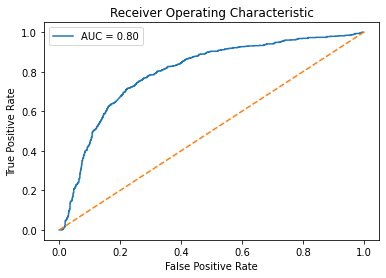

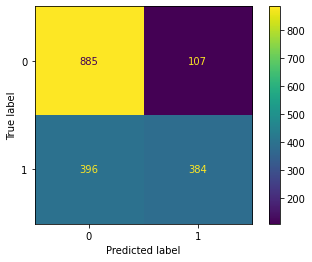

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import model_selection

from sklearn.metrics import precision_score
test_image_features = feature_extractorFOS(X_test)
y_pred = svmI.predict(test_image_features)

# calculate accuracyprecision = precision_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
#from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print('Model precision is: ', precision)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1 score is',f1)
# predict probabilities for X_test using predict_proba
probabilities = svmI.predict_proba(test_image_features)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision','f1','roc_auc']
#X_for_ML_CV=feature_extractorGLCM(X)
print(cross_validate(svmI, X_for_ML_CV, test_labels_encoded, scoring=scoring, cv = 5))
mean_score = cross_validate(svmI, X_for_ML, y_train, scoring="accuracy", cv = 5).mean()
std_score = cross_validate(svmI, X_for_ML, y_train, scoring="accuracy", cv = 5).std()
print(mean_score)
print(std_score)
mean_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="precision", cv = 5).mean()
std_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="precision", cv = 5).std()
print(mean_score)
print(std_score)
mean_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="f1", cv = 5).mean()
std_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="f1", cv = 5).std()
print(mean_score)
print(std_score)
mean_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="roc_auc", cv = 5).mean()
std_score = cross_validate(svmI, X_for_ML_CV, y_train, scoring="roc_auc", cv = 5).std()
print(mean_score)
print(std_score)


{'fit_time': array([19.94585633, 32.52487397, 35.97305012, 33.43183351, 28.77944779]), 'score_time': array([2.17652297, 2.60755944, 2.67432404, 2.60511208, 2.26168513]), 'test_accuracy': array([0.66314977, 0.93154915, 0.91943372, 0.92638353, 0.82985843]), 'test_precision': array([0.94576271, 0.93147816, 0.90961594, 0.91676368, 0.82655471]), 'test_f1': array([0.74899329, 0.95902649, 0.95266899, 0.95657455, 0.90504238]), 'test_roc_auc': array([0.8033838 , 0.96121851, 0.95638311, 0.92182443, 0.81311305])}


AttributeError: ignored

In [ ]:
image_featuresF = feature_extractorFOS(X_train)
X_for_MLF = image_featuresF
svmF = SVC(kernel='rbf',probability=True, random_state=8)
# fit model
svmF.fit(X_for_MLF, y_train)
print('Model Fitted Successfully')


Model Fitted Successfully


Model accuracy is:  0.7308126410835214
f1 score is 0.6310904872389792


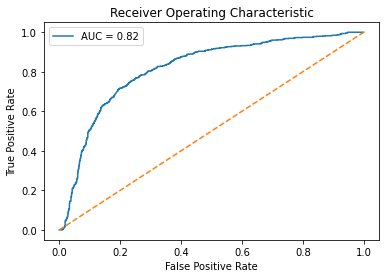

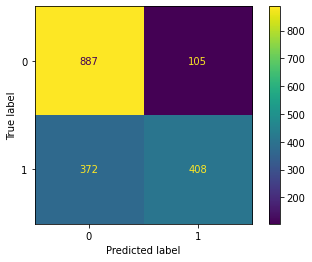

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import model_selection
test_image_featuresF = feature_extractorFOS(X_test)
y_pred = svmF.predict(test_image_featuresF)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1 score is',f1)
# predict probabilities for X_test using predict_proba
probabilities = svmF.predict_proba(test_image_featuresF)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
!pip install PyWavelets
import pywt
(cA, cD) = pywt.dwt(X[0], 'db1')
cA


In [ ]:
caArray = np.array(cA)
caArray


In [ ]:
def feature_extractorDWT(dataset):
    image_dataset = []
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
       #print(image)
       cA, cD = pywt.dwt(dataset[image], 'db1')
       #cA == LL coefficient of approximation
       ca2dArray = np.array(cA)
       caArray = ca2dArray.flatten()
       image_dataset.append(caArray)
    return image_dataset

In [ ]:
image_featuresDWT = feature_extractorDWT(X_train)
X_for_ML_DWT = image_featuresDWT
svmIII = SVC(kernel='rbf', probability=True)

# fit model
svmIII.fit(X_for_ML_DWT, y_train)
print('Model Fitted Successfully')

Model Fitted Successfully


Model accuracy is:  0.8075620767494357
f1 score is 0.7898952556993223


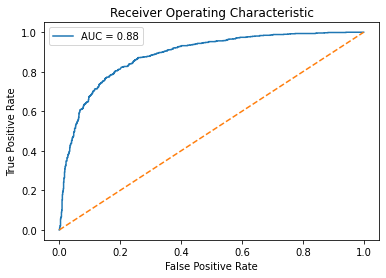

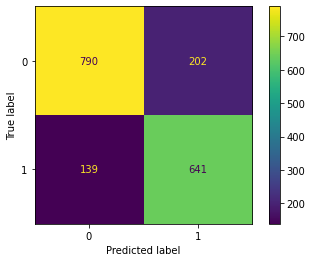

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
test_image_features_DWT = feature_extractorDWT(X_test)
y_pred = svmIII.predict(test_image_features_DWT)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1 score is',f1)
# predict probabilities for X_test using predict_proba
probabilities = svmIII.predict_proba(test_image_features_DWT)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
scoring = ['accuracy', 'precision','f1','roc_auc']
X_for_ML_CV_DWT=feature_extractorDWT(X)
print(cross_validate(svmI, X_for_ML_CV_DWT, test_labels_encoded, scoring=scoring, cv = 7))

{'fit_time': array([211.59091663, 251.96781182, 256.82045674, 256.46486831,
       285.52894258]), 'score_time': array([26.98151064, 24.80917859, 31.29229188, 30.47601986, 30.82617331]), 'test_accuracy': array([0.72645394, 0.90710242, 0.91840412, 0.93024453, 0.91068211]), 'test_precision': array([0.94048122, 0.92373139, 0.91141446, 0.92677142, 0.90919708]), 'test_f1': array([0.80739264, 0.9439528 , 0.9519187 , 0.9584547 , 0.94722433]), 'test_roc_auc': array([0.83412569, 0.94496592, 0.97584019, 0.96975143, 0.94488284])}


In [ ]:
print(cross_validate(svmI, X_for_ML_CV_DWT, test_labels_encoded, scoring=scoring, cv = 7))

In [ ]:
DATADIR = r'/content/drive/MyDrive/Semester 8'
Categories=['Healthy32x32','Infected32x32']


for i in Categories:
    path=os.path.join(DATADIR,i)
    newCat = i+'HE'
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = cv.imread(newpath,-1)
      equ = cv.equalizeHist(image)
      imageio.imwrite(f'/content/drive/MyDrive/Semester 8/{newCat}/{imgX}',equ )
      #print(imArr)
      X.append(imArr)
      y.append(i)

print(X[0])

[[207 220 214 ... 254 225 182]
 [234 244 251 ... 194 183 188]
 [225 208 216 ... 154 154 172]
 ...
 [187 167 179 ...  11  12  28]
 [210 178 207 ...  13  40  73]
 [245 201 204 ...  22  55  88]]


In [ ]:
strX = 'skdj'
strY = strX+ 'HE'
strY

'skdjHE'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model2 = KNeighborsClassifier(n_neighbors=4)
feat = feature_extractorFOS(X_train)
model2.fit(feat,y_train)
print('fitted successfully')


fitted successfully


0.5645430660151582


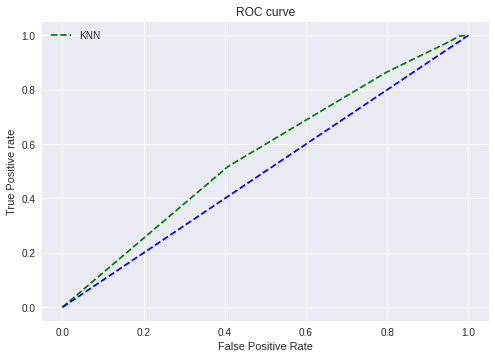

In [ ]:
testFeat = feature_extractorFOS(X_test)
pred_prob2 = model2.predict_proba(testFeat)
from sklearn.metrics import roc_curve

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score

# auc scores
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print( auc_score2)
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
#plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#featRFtrain = feature_extractorGLCM(X_train)
image_featuresDWT = feature_extractorGLCM(X_train)
X_for_ML_DWT = image_featuresDWT
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_for_ML_DWT, y_train)
import pickle
filename = '/content/drive/MyDrive/Semester_8/DWT_SVM_RBF_LS_binWidth1_Med2Img.sav'
pickle.dump(clf, open(filename, 'wb'))

Model accuracy is:  0.8290067720090294
Model precision is:  0.8298530357133614
f1 score is 0.8088328075709779


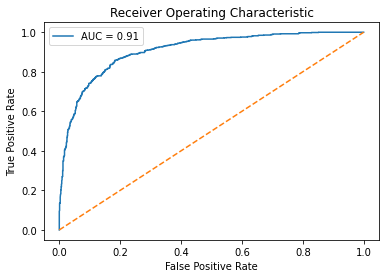

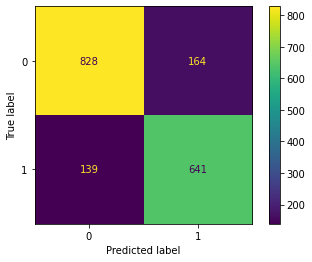

In [ ]:
featRFtest = feature_extractorGLCM(X_test)
y_pred = clf.predict(featRFtest)
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
print('Model accuracy is: ', accuracy)
print('Model precision is: ', precision)
# predict probabilities for X_test using predict_proba
f1 = f1_score(y_test, y_pred)
print('f1 score is',f1)
probabilities = clf.predict_proba(featRFtest)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
X_for_ML_CV=feature_extractorGLCM(X)
print(cross_validate(clf, X_for_ML_CV, test_labels_encoded, scoring=scoring, cv = 7))


NameError: ignored

In [ ]:
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'precision','f1','roc_auc']
X_for_ML_CV=feature_extractorGLCM(X)
print(cross_validate(clf, X_for_ML_CV, test_labels_encoded, scoring=scoring, cv = 7))

{'fit_time': array([0.60520744, 0.60514498, 0.63261104, 0.61093473, 0.61372352,
       0.59985662, 0.59883428]), 'score_time': array([0.04076362, 0.03699994, 0.04014063, 0.03806353, 0.03797102,
       0.03785992, 0.03709149]), 'test_accuracy': array([0.76066351, 0.73933649, 0.75829384, 0.82306477, 0.83715415,
       0.7826087 , 0.82766798]), 'test_precision': array([0.84367246, 0.80740741, 0.78980892, 0.84872299, 0.7558299 ,
       0.72418879, 0.78787879]), 'test_f1': array([0.69175992, 0.66463415, 0.70857143, 0.79411765, 0.84250765,
       0.78122514, 0.81923715]), 'test_roc_auc': array([0.83361818, 0.83456771, 0.83782836, 0.88312304, 0.94100238,
       0.89201624, 0.90031571])}


In [ ]:
from radiomics import glszm
def feature_extractorGLSZM(dataset):
    image_dataset = pd.DataFrame()
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(dataset[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester_8/mask.nrrd')
        applyLog = True
        applyWavelet = False
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)




        glszmFeatures = glszm.RadiomicsGLSZM(iterImg, trialMask ,**settings)
        glszmFeatures.enableAllFeatures()

        radiomics.setVerbosity(40)
        results = glszmFeatures.execute()
        df = pd.DataFrame()
        #Append features from current image to the dataset
        df = df.append({'SmallAreaEmphasis': results['SmallAreaEmphasis'],
                       'LargeAreaEmphasis': results['LargeAreaEmphasis'],
                        'GrayLevelNonUniformity': results['GrayLevelNonUniformity'],
        #                'GrayLevelNonUniformityNormalized': results['GrayLevelNonUniformityNormalized'],
                        'SizeZoneNonUniformity': results['SizeZoneNonUniformity'],
        #                'SizeZoneNonUniformityNormalized': results['SizeZoneNonUniformityNormalized'],
                       'ZonePercentage': results['ZonePercentage'],
                        'GrayLevelVariance': results['GrayLevelVariance'],
                        'ZoneVariance': results['ZoneVariance'],
        #                'ZoneEntropy': results['ZoneEntropy'],
                          'LowGrayLevelZoneEmphasis': results['LowGrayLevelZoneEmphasis'],
                        'HighGrayLevelZoneEmphasis': results['HighGrayLevelZoneEmphasis'],
                          'SmallAreaLowGrayLevelEmphasis': results['SmallAreaLowGrayLevelEmphasis'],
                         'SmallAreaHighGrayLevelEmphasis': results['SmallAreaHighGrayLevelEmphasis'],
                        'LargeAreaLowGrayLevelEmphasis': results['LargeAreaLowGrayLevelEmphasis'],
                        'LargeAreaHighGrayLevelEmphasis': results['LargeAreaHighGrayLevelEmphasis']
                       },
                       ignore_index=True)

        image_dataset = image_dataset.append(df,ignore_index=True)
    return image_dataset

In [ ]:

image_features_GLSZM = feature_extractorGLSZM(X_train)
X_for_ML_GLSZM = image_features_GLSZM
svm_GLSZM = SVC(kernel='rbf',probability=True)
# fit model
svm_GLSZM.fit(X_for_ML_GLSZM, y_train)
print('Model Fitted Successfully')

Model Fitted Successfully


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model precision is:  0.0
Model accuracy is:  0.5598194130925508
f1 score is 0.0


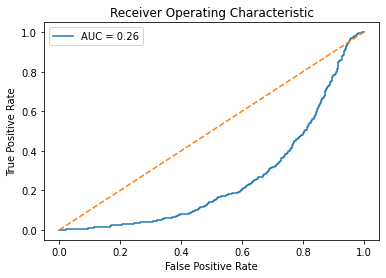

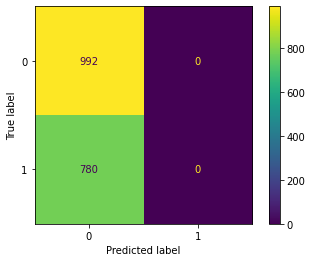

In [ ]:
test_image_features_GLSZM = feature_extractorGLSZM(X_test)
y_pred_GLSZM = svm_GLSZM.predict(test_image_features_GLSZM)

precision = precision_score(y_test, y_pred_GLSZM)
print('Model precision is: ', precision)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_GLSZM)
print('Model accuracy is: ', accuracy)
f1 = f1_score(y_test, y_pred_GLSZM)
print('f1 score is',f1)
# predict probabilities for X_test using predict_proba
probabilities = svm_GLSZM.predict_proba(test_image_features_GLSZM)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_GLSZM)
plt.show()

In [ ]:
from radiomics import glrlm
def feature_extractorGLRLM(dataset):
    image_dataset = []
    for image in range(len(dataset)):   #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        iterImg = sitk.GetImageFromArray(dataset[image])
        trialMask = sitk.ReadImage(r'/content/drive/MyDrive/Semester_8/mask.nrrd')
        applyLog = False
        applyWavelet = False
        interpolator = settings.get('interpolator')
        resampledPixelSpacing = settings.get('resampledPixelSpacing')
        if interpolator is not None and resampledPixelSpacing is not None:
          image, mask = imageoperations.resampleImage(iterImg, trialMask, **settings)




        glrlmFeatures = glrlm.RadiomicsGLRLM(iterImg, trialMask ,**settings)
        glrlmFeatures.enableAllFeatures()


        results = glrlmFeatures.execute()
        #Append features from current image to the dataset
        arrTrX = []
        for (key, val) in six.iteritems(results):
           arrTrX.append(float(val))


        image_dataset.append(arrTrX)
    return image_dataset

In [ ]:
image_features_RLM = feature_extractorGLRLM(X_train)
X_for_ML_RLM = image_features_RLM
svm_RLM = SVC(kernel='rbf',probability=True, random_state=8)
# fit model
svm_RLM.fit(X_for_ML_RLM, y_train)
print('Model Fitted Successfully')

Model Fitted Successfully


Model precision is:  0.5609043479740693
Model accuracy is:  0.5660270880361173
f1 score is 0.12910532276330694


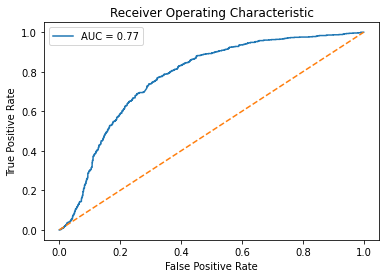

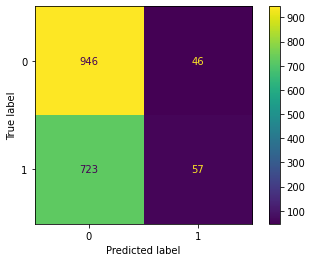

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
test_image_features_RLM = feature_extractorGLRLM(X_test)
y_pred = svm_RLM.predict(test_image_features_RLM)
precision = precision_score(y_test, y_pred, average='weighted')
print('Model precision is: ', precision)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1 score is',f1)
# predict probabilities for X_test using predict_proba
probabilities = svm_RLM.predict_proba(test_image_features_RLM)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
 !pip install scaleogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement wavelets (from versions: none)
ERROR: No matching distribution found for wavelets


NameError: ignored

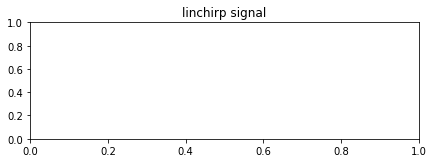

In [ ]:

import matplotlib.cm as cm
import pylab

import pywt
f = pylab.figure()
f.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
pylab.subplot(2, 1, 1)
pylab.title("linchirp signal")
pylab.plot(x, data, 'b')
pylab.xlim(0, x[-1])

ax = pylab.subplot(2, 1, 2)
pylab.title("Wavelet packet coefficients at level %d" % level)
pylab.imshow(cA, interpolation=interpolation, cmap=cmap, aspect="auto",
    origin="lower", extent=[0, 1, 0, len(values)])
pylab.yticks(pylab.arange(0.5, len(labels) + 0.5), labels)

In [ ]:
filename = '/content/drive/MyDrive/Semester_8/DWT_SVM_RBF_LS_binWidth1_Med2Img.sav'

fModel = pickle.load( open( filename, "rb" ) )
def checkModel(x,y,imgArr):
    x*=32
    y*=32
    outII =0
    for i2 in range(x,x+32):
        for j2 in range(y,y+32):
            if imgArr[i2][j2]==0:
                outII+=1
    if outII< 100:
      return True
    return False
medHEpath = r'/content/drive/MyDrive/Semester_8/DatasetII/Lung/01Lung'
lastStrawLungPath = r'/content/drive/MyDrive/Semester_8/DatasetII/LungMask/01LungMask'
lastStrawCovidPath = r'/content/drive/MyDrive/Semester_8/DatasetII/CVDMask/01CovidMask'
for ctPtr in range(45):
    ctPtr=33
    strPtr = str(ctPtr)
    if(ctPtr<10):
      strPtr= str('0')+strPtr
    if(ctPtr<100):
      strPtr= str('0')+strPtr
    cvdPtr = '01_CVDMask-slice'+strPtr+'.jpg'
    lngPtr= '01_LungMask-slice'+strPtr+'.jpg'
    dataPtr = '01_Lung-slice'+strPtr+'.jpg'
    currentCT =  cv.imread(os.path.join(medHEpath,dataPtr),0)
    currentMask = cv.imread(os.path.join(lastStrawCovidPath,cvdPtr),0)
    currentLungMask = cv.imread(os.path.join(lastStrawLungPath,lngPtr),0)
    zeft= cv.imread(os.path.join(medHEpath,dataPtr),0)

    detectedInfectedArr = []
    detectedNonInfectedArr = []
    i=0
    j=0
    for i in range(19):
        for j in range(19):
          if(checkForLung(i, j, currentLungMask )):
                detectedInfectedArr.append((i,j))
    c=0
    d=0
    for c in range(len(detectedInfectedArr)) :
        #10010_
        imgID = 88855+ctPtr
        patchIDSub=  20000+c
        patchID =str(imgID)+'_'+str(patchIDSub)
        currentPatch = currentCT[detectedInfectedArr[c][0]*32:(detectedInfectedArr[c][0]*32)+32,detectedInfectedArr[c][1]*32:(detectedInfectedArr[c][1]*32)+32]
        # print(x1,x2,y1,y2)
        imageio.imwrite(f'/content/drive/MyDrive/Semester_8/testIII/{patchID}.png',currentPatch)
        #imageio.imwrite(f'/content/drive/MyDrive/Semester_8/08Infected32x32/{patchID}.png',currentPatch )
        #cv.rectangle(currentCT,(((detectedInfectedArr[c][1]*32)+32,(detectedInfectedArr[c][0]*32)+32)),(detectedInfectedArr[c][1]*32,detectedInfectedArr[c][0]*32),(255,255,255),thickness=2)


    break

In [ ]:
filename = '/content/drive/MyDrive/Semester_8/DWT_SVM_RBF_LS_binWidth1_Med2Img.sav'

fModel = pickle.load( open( filename, "rb" ) )
def checkModel(x,y,imgArr):
    x*=32
    y*=32
    outII =0
    for i2 in range(x,x+32):
        for j2 in range(y,y+32):
            if imgArr[i2][j2]==0:
                outII+=1
    if outII< 100:
      return True
    return False
DATADIR = r'/content/drive/MyDrive/Semester_8'
Categories=['testIII']

X=[]
y=[]
i=0

for i in Categories:
    path=os.path.join(DATADIR,i)
    for imgX in os.listdir(path):
      #print(path)
      newpath = os.path.join(path,imgX)
      #print(newpath)
      image = cv.imread(newpath,0)
      imArr = np.array(image)
      #print(imArr)
      X.append(imArr)
finallfeat = feature_extractorGLCM(X)
y_pred = clf.predict(finallfeat)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

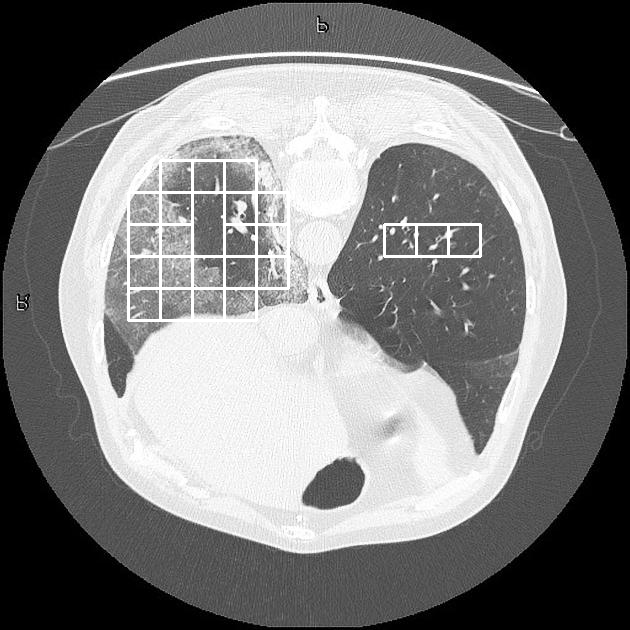

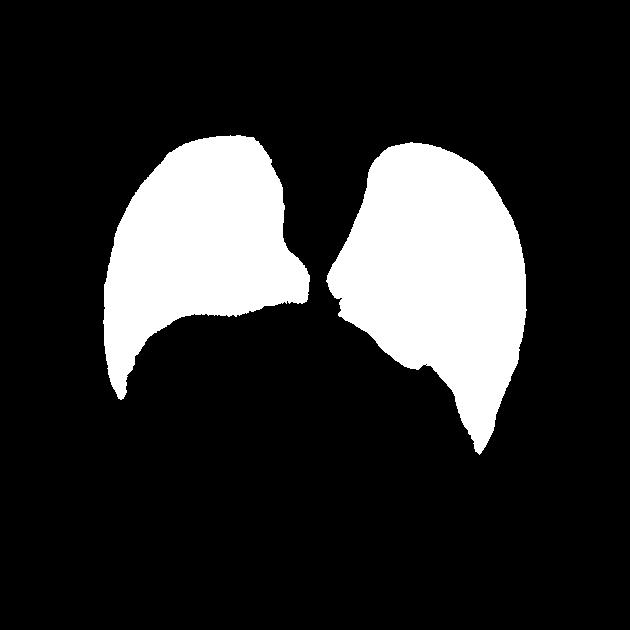

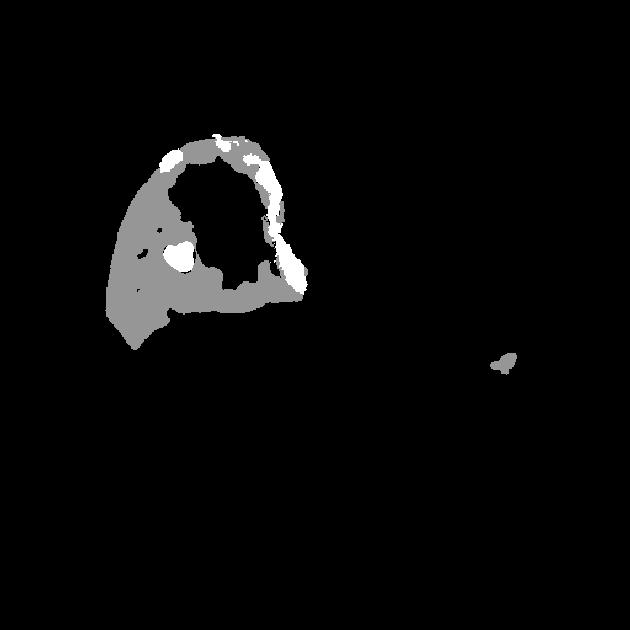

In [ ]:
ef=0
er=0
for ef in range(len(detectedInfectedArr)):
  if(y_pred[ef])==0:
    cv.rectangle(currentCT,(((detectedInfectedArr[ef][1]*32)+32,(detectedInfectedArr[ef][0]*32)+32)),(detectedInfectedArr[ef][1]*32,detectedInfectedArr[ef][0]*32),(255,255,255),thickness=2)


cv2_imshow(currentCT)
cv.waitKey(0)
cv.destroyAllWindows()
cv2_imshow(currentLungMask)
cv.waitKey(0)
cv.destroyAllWindows()
cv2_imshow(currentMask)
cv.waitKey(0)
cv.destroyAllWindows()

In [ ]:
def checkForLung(x,y,imgArr):
    x*=32
    y*=32
    outII =0
    for i2 in range(x,x+32):
        for j2 in range(y,y+32):
            if imgArr[i2][j2]==0:
                outII+=1
    if outII< 100:
      return True
    return False
for ctPtr in range(45):
    ctPtr=33
    strPtr = str(ctPtr)
    if(ctPtr<10):
      strPtr= str('0')+strPtr
    if(ctPtr<100):
      strPtr= str('0')+strPtr
    cvdPtr = '01_CVDMask-slice'+strPtr+'.jpg'
    lngPtr= '01_LungMask-slice'+strPtr+'.jpg'
    dataPtr = '01_Lung-slice'+strPtr+'.jpg'
    currentCT =  cv.imread(os.path.join(medHEpath,dataPtr),0)
    currentMask = cv.imread(os.path.join(lastStrawCovidPath,cvdPtr),0)
    currentLungMask = cv.imread(os.path.join(lastStrawLungPath,lngPtr),0)
    zeft= cv.imread(os.path.join(medHEpath,dataPtr),0)

    detectedInfectedArr = []
    detectedNonInfectedArr = []
    i=0
    j=0
    for i in range(19):
        for j in range(19):
                if checkForLung(i, j, currentLungMask ):
                    detectedNonInfectedArr.append((i,j))
    c=0
    d=0
    for c in range(len(detectedInfectedArr)) :
        #10010_
        imgID = 88855+ctPtr
        patchIDSub=  20000+c
        patchID =str(imgID)+'_'+str(patchIDSub)
        currentPatch = currentCT[detectedNonInfectedArr[c][0]*32:(detectedNonInfectedArr[c][0]*32)+32,detectedNonInfectedArr[c][1]*32:(detectedNonInfectedArr[c][1]*32)+32]
        # print(x1,x2,y1,y2)
        imageio.imwrite(f'/content/drive/MyDrive/Semester_8/testIII/{patchID}.png',currentPatch)
    break